In [4]:
# import requirments ---------------------------
from brian2 import *
import math as math
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from control.matlab import *            # Similar to MATLAB functions

from initialization import *

<Figure size 640x480 with 0 Axes>

In [5]:
# Neuron synapses moedel which is obtained from an exponential distribution
def createNeuronsConnections(params):
    # 3D connection of neurons and synaptic connections
    Post         = np.zeros((params.mneuro, params.nneuro, params.N_connections), dtype=np.int16)
    ties_stock   = 2000 * params.N_connections
    
    for i in range(0, params.mneuro):
        for j in range(0, params.nneuro):              
            XY      = np.zeros((2, ties_stock), dtype=np.int8)
            R       = np.random.exponential(scale=params.lambdagain, size=ties_stock)
            fi      = 2 * np.pi * np.random.rand(1, ties_stock)
            XY[0,:] = np.int16(R * np.cos(fi))
            XY[1,:] = np.int16(R * np.sin(fi))
            _, idx  = np.unique(XY, axis=1, return_index=True)
            XY      = XY[:, np.sort(idx)] # returns the same data with no repetition
            n       = 0
            
            for k in range(0, np.size(XY, 1)):
                x = i + XY[0, k]
                y = j + XY[1, k]
                # This is distance condition, with sin and cos we applied a distance condition == 1
                # this line will evaluate that == 0
                pp = 1 if i==x and j == y else 0
                if (x>=0 and y>=0 and x<params.mneuro and y<params.nneuro and pp==0):
                    # Returns the linear index equivalents to the rows(x) and columns(y) (based on MATLAB)
                    Post[i,j,n] = y*params.mneuro + x
                    n += 1
                if n >= params.N_connections: break
    # End for

    Post2 = Post.transpose(2,0,1)
    Post_line = Post2.T.flatten()
    Pre_line = np.zeros(np.size(Post_line), dtype=np.int16)
    k = 0
    for i in range(0, np.size(Post_line), params.N_connections):
        Pre_line[i:(i + params.N_connections)] = k
        k = k + 1
    return [Pre_line.flatten(), Post_line.flatten()]
# the end of the function

In [8]:
lib = loadLibraries()
params = valuation(lib, 0)
Pree, Postt = createNeuronsConnections(params)

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 2 lines of abstract code, first line is: 'Smoother := 1.0 / (1.0 + exp(_lio_1 * (- v_pre))) (constant)'
 [brian2.codegen.generators.base]


Text(0, 0.5, 'v')

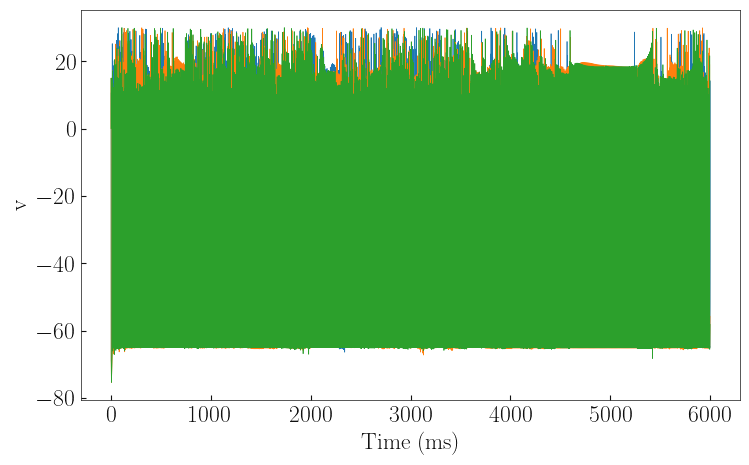

In [68]:
start_scope()

N = 100
a = 0.1     # Time scale of the recovery variable
b = 0.2     # Sensitivity of the recovery variable to the sub-threshold fluctuations of the membrane potential
c = -65     # After-spike reset value of the membrane potential
d = 2       # After-spike reset value of the recovery variable
aep = 1.2
gsyn = 0.05
Esyn = 0
ksyn = 6
Iapp = 10
eqs = '''
    dv/dt = (0.04*(v**2) + 5*v - u + 140 + Iapp + Isyn)/ms : 1
    du/dt = (a*(b*v - u))/ms : 1
    Isyn : 1
'''
reset = '''
    v  = c
    u += d
'''

G = NeuronGroup(N, eqs, threshold='v>30', reset=reset, method='euler')
G.v[0] = 'rand()*30'
G.Isyn = 0

synPrep = '''
    Smoother  = 1 / (1 + exp((-v_pre / ksyn)))
    Isyn_post = gsyn * Smoother * (Esyn - v_post)
'''
S = Synapses(G, G, on_pre=synPrep)
S.connect(i=Pree, j=Postt)

M = StateMonitor(G, 'v', record=True)
run(6*second)




plot(M.t/ms, M.v[0])
plot(M.t/ms, M.v[1])
plot(M.t/ms, M.v[2])
xlabel('Time (ms)')
ylabel('v')


In [90]:
a = np.hstack([[c, c, c, 0, 0] for c in np.random.rand(2)])
a

array([0.41850041, 0.41850041, 0.41850041, 0.        , 0.        ,
       0.45642719, 0.45642719, 0.45642719, 0.        , 0.        ])

In [97]:
stimulus = TimedArray(np.hstack([[c, c, c, 0, 0] for c in np.random.rand(2)]), dt=10*ms)
stimulus.values

array([0.41850041, 0.41850041, 0.41850041, 0.        , 0.        ,
       0.45642719, 0.45642719, 0.45642719, 0.        , 0.        ])

In [ ]:
np.hstack([[c, c, c, 0, 0] for c in np.random.rand(1000)])